# Real Estate Investment Analysis

What makes a zip code a hotspot for real estate investments? In the ever-evolving world of real estate, understanding market dynamics is essential for making informed investment decisions. This project explores the U.S. housing market through an extensive dataset, aiming to identify the key factors that influence rental investment potential. By analyzing metrics such as property prices, rental rates, population trends, and economic indicators, we seek to answer pressing questions:

- Where are the best opportunities for profitable rental investments?
- How do factors like income levels, educational attainment, and employment rates impact housing affordability?
- What market characteristics can help investors pinpoint areas with strong growth potential?

The dataset combines information from various sources, including Zillow property and rent prices, U.S. Census Bureau population data, and American Community Survey economic metrics. By integrating and analyzing this data, the project provides actionable insights to guide investment strategies in the real estate market.

Through this analysis, we aim to empower investors with a data-driven approach to navigating the complexities of real estate investment, helping them identify lucrative opportunities and avoid potential pitfalls.

## Data Cleaning and Preparation

### Loading Datasets
We begin by uploading raw CSV files to [Google Cloud Storage](https://cloud.google.com/storage), which contain data on property prices, rent prices, population, median age, homeownership rates, employment rates, educational attainment, and income. These files, originally sourced from Zillow and the U.S. Census Bureau, were prepared and organized locally before being uploaded to the cloud. Once stored in Google Cloud Storage, the files are imported into pandas DataFrames for cleaning, transformation, and analysis.

In [1]:
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from google.cloud import storage
from io import StringIO

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./real-estate-analysis-448315-e9a39dc195b8.json"

client = storage.Client()
bucket_name = "real_estate_and_demographic_data"
bucket = client.get_bucket(bucket_name)

file_mapping = {
    "ACSDP5Y2023.DP03-Data.csv": {"key": "Employment_Rate_Data", "skiprows": 1},
    "ACSDP5Y2023.DP04-Data.csv": {"key": "Homeownership_Data", "skiprows": 1},
    "ACSDT5Y2020.B19001-Data.csv": {"key": "Income_Data", "skiprows": 1},
    "ACSST5Y2023.S0101-Data.csv": {"key": "Age_Distribution_Data", "skiprows": 1},
    "ACSST5Y2023.S1501-Data.csv": {"key": "Educational_Attainment_Data", "skiprows": 1},
    "DECENNIALSF12010.P1-Data.csv": {"key": "Population_2010_Data", "skiprows": 1},
    "DECENNIALDHC2020.P1-Data.csv": {"key": "Population_2020_Data", "skiprows": 1},
    "zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv": {"key": "Property_Prices_Data", "skiprows": 0},
    "zip_zori_uc_sfrcondomfr_sm_sa_month.csv": {"key": "Rent_Prices_Data", "skiprows": 0},
}

dataframes = {}

for blob_name, params in file_mapping.items():
    blob = bucket.blob(blob_name)
    content = blob.download_as_text()
    skiprows = params.get("skiprows", 0)
    df = pd.read_csv(StringIO(content), skiprows=skiprows, low_memory=False)
    dataframes[params["key"]] = df

for key, df in dataframes.items():
    print(f"\nFirst rows of {key}:")
    print(df.head())


First rows of Employment_Rate_Data:
        Geography Geographic Area Name  \
0  860Z200US00601          ZCTA5 00601   
1  860Z200US00602          ZCTA5 00602   
2  860Z200US00603          ZCTA5 00603   
3  860Z200US00606          ZCTA5 00606   
4  860Z200US00610          ZCTA5 00610   

   Estimate!!EMPLOYMENT STATUS!!Population 16 years and over  \
0                                              14106           
1                                              32600           
2                                              41422           
3                                               4665           
4                                              22100           

   Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over  \
0                                                448                  
1                                                242                  
2                                                858                  
3                                        

The property and rent datasets are loaded, and the column ```RegionName``` is renamed to ZipCode for consistency. This ensures that data from different datasets can be joined using ZipCode as a common key.

In [3]:
median_property_prices_by_zip_data = dataframes["Property_Prices_Data"]
median_property_prices_by_zip_data.rename(columns={"RegionName": "ZipCode"}, inplace=True)
median_property_prices_by_zip_data["ZipCode"] = median_property_prices_by_zip_data["ZipCode"].astype(str)


median_property_prices_by_zip_data = median_property_prices_by_zip_data[
    median_property_prices_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

threshold = 0.3  
median_property_prices_by_zip_data = median_property_prices_by_zip_data[
    median_property_prices_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_property_summary = median_property_prices_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_property_summary)


print('Property Prices\n', median_property_prices_by_zip_data.head())

Missing Data Summary:
 RegionID      0
SizeRank      0
ZipCode       0
RegionType    0
StateName     0
             ..
2024-08-31    1
2024-09-30    1
2024-10-31    1
2024-11-30    0
2024-12-31    0
Length: 309, dtype: int64
Property Prices
    RegionID  SizeRank ZipCode RegionType StateName State      City  \
0     91982         1   77494        zip        TX    TX      Katy   
2     91940         3   77449        zip        TX    TX      Katy   
3     62080         4   11368        zip        NY    NY  New York   
4     91733         5   77084        zip        TX    TX   Houston   
5     93144         6   79936        zip        TX    TX   El Paso   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  208873.462679   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103665.724381   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  147260.760117   
4   Houston-The Woodlands-Sug

In [4]:
median_rent_prices_by_zip_data = dataframes["Rent_Prices_Data"]
median_rent_prices_by_zip_data.rename(columns={"RegionName": "ZipCode"}, inplace=True)
median_rent_prices_by_zip_data["ZipCode"] = median_rent_prices_by_zip_data["ZipCode"].astype(str)

median_rent_prices_by_zip_data = median_rent_prices_by_zip_data[
    median_rent_prices_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

threshold = 0.3 
median_rent_prices_by_zip_data = median_rent_prices_by_zip_data[
    median_rent_prices_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = median_rent_prices_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)

print('Rent Prices\n', median_rent_prices_by_zip_data.head())

Missing Data Summary:
 RegionID      0
SizeRank      0
ZipCode       0
RegionType    0
StateName     0
             ..
2024-08-31    0
2024-09-30    0
2024-10-31    0
2024-11-30    1
2024-12-31    0
Length: 129, dtype: int64
Rent Prices
    RegionID  SizeRank ZipCode RegionType StateName State          City  \
0     91982         1   77494        zip        TX    TX          Katy   
2     91940         3   77449        zip        TX    TX          Katy   
3     91733         5   77084        zip        TX    TX       Houston   
5     62093         7   11385        zip        NY    NY      New York   
6     92593         8   78660        zip        TX    TX  Pflugerville   

                                   Metro        CountyName   2015-01-31  ...  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  1523.456017  ...   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  1297.286078  ...   
3   Houston-The Woodlands-Sugar Land, TX     Harris County  1199.477203  ... 

Population data for 2010 and 2020 is processed to clean up column names and standardize ```ZipCode```. We calculate the population growth percentage to understand demographic trends, which can influence housing demand and affordability.

In [5]:
population_2010_by_zip_data = dataframes["Population_2010_Data"]
population_2020_by_zip_data = dataframes["Population_2020_Data"]

rename_dict = {
    "Geographic Area Name": "ZipCode",
    "Total": "Total_Population",
    "!!Total": "Total_Population"
}

population_2010_by_zip_data.columns = population_2010_by_zip_data.columns.str.strip()
population_2020_by_zip_data.columns = population_2020_by_zip_data.columns.str.strip()


population_2010_by_zip_data.rename(columns=rename_dict, inplace=True)
population_2010_by_zip_data["ZipCode"] = population_2010_by_zip_data["ZipCode"].str[-5:] 
population_2010_by_zip_data["ZipCode"] = population_2010_by_zip_data["ZipCode"].astype(str)

population_2010_by_zip_data = population_2010_by_zip_data[
    population_2010_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

threshold = 0.3 
population_2010_by_zip_data = population_2010_by_zip_data[
    population_2010_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = population_2010_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)


population_2020_by_zip_data.rename(columns=rename_dict, inplace=True)
population_2020_by_zip_data["ZipCode"] = population_2020_by_zip_data["ZipCode"].str[-5:] 

population_2020_by_zip_data["ZipCode"] = population_2020_by_zip_data["ZipCode"].astype(str)

population_2020_by_zip_data = population_2020_by_zip_data[
    population_2020_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

threshold = 0.3 
population_2020_by_zip_data = population_2020_by_zip_data[
    population_2020_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = median_rent_prices_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)

population_2010_by_zip_data = population_2010_by_zip_data[['ZipCode', 'Total_Population']]
population_2020_by_zip_data = population_2020_by_zip_data[['ZipCode', 'Total_Population']]

population_data = pd.merge(
    population_2010_by_zip_data,
    population_2020_by_zip_data,
    on="ZipCode",
    suffixes=('_2010', '_2020')
)

population_data["Growth_Percentage"] = (
    (population_data["Total_Population_2020"] - population_data["Total_Population_2010"]) /
    population_data["Total_Population_2010"]
) * 100

print(population_data.head())

Missing Data Summary:
 Geography               0
ZipCode                 0
Total_Population        0
Unnamed: 3          33120
dtype: int64
Missing Data Summary:
 RegionID      0
SizeRank      0
ZipCode       0
RegionType    0
StateName     0
             ..
2024-08-31    0
2024-09-30    0
2024-10-31    0
2024-11-30    1
2024-12-31    0
Length: 129, dtype: int64
  ZipCode  Total_Population_2010  Total_Population_2020  Growth_Percentage
0   00601                  18570                  17242          -7.151319
1   00602                  41520                  37548          -9.566474
2   00603                  54689                  49804          -8.932326
3   00606                   6615                   5009         -24.278156
4   00610                  29016                  25731         -11.321340


Age distribution data is cleaned and processed to calculate an approximate median age for each zip code. Median age is a demographic factor that could potentially correlate with housing preferences and market stability.

In [6]:
median_age_by_zip_data = dataframes["Age_Distribution_Data"]

age_groups = {
    "Estimate!!Total!!Total population!!AGE!!Under 5 years": 2,
    "Estimate!!Total!!Total population!!AGE!!5 to 9 years": 7,
    "Estimate!!Total!!Total population!!AGE!!10 to 14 years": 12,
    "Estimate!!Total!!Total population!!AGE!!15 to 19 years": 17,
    "Estimate!!Total!!Total population!!AGE!!20 to 24 years": 22,
    "Estimate!!Total!!Total population!!AGE!!25 to 29 years": 27,
    "Estimate!!Total!!Total population!!AGE!!30 to 34 years": 32,
    "Estimate!!Total!!Total population!!AGE!!35 to 39 years": 37,
    "Estimate!!Total!!Total population!!AGE!!40 to 44 years": 42,
    "Estimate!!Total!!Total population!!AGE!!45 to 49 years": 47,
    "Estimate!!Total!!Total population!!AGE!!50 to 54 years": 52,
    "Estimate!!Total!!Total population!!AGE!!55 to 59 years": 57,
    "Estimate!!Total!!Total population!!AGE!!60 to 64 years": 62,
    "Estimate!!Total!!Total population!!AGE!!65 to 69 years": 67,
    "Estimate!!Total!!Total population!!AGE!!70 to 74 years": 72,
    "Estimate!!Total!!Total population!!AGE!!75 to 79 years": 77,
    "Estimate!!Total!!Total population!!AGE!!80 to 84 years": 82,
    "Estimate!!Total!!Total population!!AGE!!85 years and over": 87,
}


median_age_by_zip_data.drop(columns=["Unnamed: 458"], inplace=True, errors="ignore")

rename_dict = {
    "Geography": "Geography",
    "Geographic Area Name": "ZipCode",
    "Estimate!!Total!!Total population": "Total_Population",
}

median_age_by_zip_data.rename(columns=rename_dict, inplace=True)

median_age_by_zip_data["ZipCode"] = median_age_by_zip_data["Geography"].str[-5:]
median_age_by_zip_data["ZipCode"] = median_age_by_zip_data["ZipCode"].astype(str)

median_age_by_zip_data = median_age_by_zip_data[
    population_2020_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

threshold = 0.3 
median_age_by_zip_data = median_age_by_zip_data[
    median_age_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = median_age_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)

# Calculate weighted average age as a proxy for median age
median_age_by_zip_data["Median_Age_Approx"] = sum(
    median_age_by_zip_data[age_col] * midpoint
    for age_col, midpoint in age_groups.items()
) / median_age_by_zip_data["Total_Population"]


median_age_by_zip_data = median_age_by_zip_data[["ZipCode", "Median_Age_Approx", "Total_Population"]]

print('Median Age\n', median_age_by_zip_data.head())

<ipython-input-6-c48706738bbb>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_age_by_zip_data = median_age_by_zip_data[


Missing Data Summary:
 Geography                                                                                        0
ZipCode                                                                                          0
Total_Population                                                                                 0
Margin of Error!!Total!!Total population                                                         0
Estimate!!Total!!Total population!!AGE!!Under 5 years                                            0
                                                                                                ..
Margin of Error!!Percent Female!!Total population!!SUMMARY INDICATORS!!Child dependency ratio    0
Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex                               0
Margin of Error!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex                        0
Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Age                    

In [7]:
filtered_data = median_age_by_zip_data.loc[
    median_age_by_zip_data['ZipCode'].isin(['02802', '02804', '02813',                  
'02814',                   
'03853',                   
'03854',                    
'04444',                 
'11581',                 
'12170',                   
'12484',                  
'12485',                    
'12512',                  
'13692',                    
'14054'])
]

print(filtered_data)

     ZipCode  Median_Age_Approx  Total_Population
671    02802          55.493409               531
672    02804          41.776400              2661
678    02813          47.352376              8017
679    02814          43.488344              7421
969    03853          61.119360               687
970    03854          51.504219               948
1178   04444          39.513409              9322
2972   11581          39.111072             22652
3213   12170          39.129187              5225
3326   12484          43.615714              3271
3327   12485          34.345951              1136
3345   12512          44.090517               232
3912   13692          56.166667               216
4037   14054          38.203091              1359


The homeownership dataset is refined to retain only relevant columns such as total housing units, occupancy status, and vacancy rates. These metrics provide insights into housing market conditions and demand across zip codes.

In [8]:
homeownership_rate_by_zip_data = dataframes["Homeownership_Data"]
homeownership_rate_by_zip_data = homeownership_rate_by_zip_data.dropna(axis=1, how='all') 
rename_dict = {
    "Geography": "Geography",
    "Geographic Area Name": "ZipCode",
    "Estimate!!HOUSING OCCUPANCY!!Total housing units": "Total_Housing_Units",
    "Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units": "Occupied_Units",
    "Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units": "Vacant_Units",
    "Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate": "Homeowner_Vacancy_Rate",
     "Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate": "Rental_Vacancy_Rate",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!20.0 to 24.9 percent": "GRAPI_20_24_Percent",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!25.0 to 29.9 percent": "GRAPI_25_29_Percent",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!30.0 to 34.9 percent": "GRAPI_30_34_Percent",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more": "GRAPI_35_Plus_Percent",
}

homeownership_rate_by_zip_data.rename(columns=rename_dict, inplace=True)
homeownership_rate_by_zip_data["ZipCode"] = homeownership_rate_by_zip_data["ZipCode"].str[-5:]  # Extract last 5 characters

homeownership_rate_by_zip_data = homeownership_rate_by_zip_data[
    homeownership_rate_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

homeownership_rate_by_zip_data["ZipCode"] = homeownership_rate_by_zip_data["ZipCode"].astype(str)


threshold = 0.3 
homeownership_rate_by_zip_data = homeownership_rate_by_zip_data[
    homeownership_rate_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = homeownership_rate_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)

columns_to_keep = [
    "ZipCode", "Total_Housing_Units", "Occupied_Units",
    "Vacant_Units", "Homeowner_Vacancy_Rate", "Rental_Vacancy_Rate",
    "GRAPI_20_24_Percent", "GRAPI_25_29_Percent", "GRAPI_30_34_Percent",
    "GRAPI_35_Plus_Percent"
]

homeownership_rate_by_zip_data = homeownership_rate_by_zip_data[columns_to_keep]

missing_data_summary = homeownership_rate_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_summary)
print('Homeownership Rate\n', homeownership_rate_by_zip_data.head())

C:\Users\mbryant\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-8-c12e0ac7935f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homeownership_rate_by_zip_data["ZipCode"] = homeownership_rate_by_zip_data["ZipCode"].str[-5:]  # Extract last 5 characters


Missing Data Summary:
 Geography                                                                                                                                                                             0
ZipCode                                                                                                                                                                               0
Total_Housing_Units                                                                                                                                                                   0
Margin of Error!!HOUSING OCCUPANCY!!Total housing units                                                                                                                               0
Occupied_Units                                                                                                                                                                        0
                                                         

In [9]:
filtered_data = homeownership_rate_by_zip_data.loc[
    homeownership_rate_by_zip_data['ZipCode'].isin(['02802', '02804', '02813',                  
'02814',                   
'03853',                   
'03854',                    
'04444',                 
'11581',                 
'12170',                   
'12484',                  
'12485',                    
'12512',                  
'13692',                    
'14054'])
]

print(filtered_data)

     ZipCode  Total_Housing_Units  Occupied_Units  Vacant_Units  \
671    02802                  384             302            82   
672    02804                 1182            1014           168   
678    02813                 5334            3481          1853   
679    02814                 3249            2879           370   
969    03853                 1310             325           985   
970    03854                  517             439            78   
1178   04444                 3936            3626           310   
2972   11581                 7423            7108           315   
3213   12170                 2327            2073           254   
3326   12484                 1479            1371           108   
3327   12485                  815             262           553   
3345   12512                  139             115            24   
3912   13692                  515              80           435   
4037   14054                  571             555            1

Employment data is processed to calculate employment and unemployment rates for the population aged 16 and older. Employment rates are a key indicator of economic health and housing affordability.

In [10]:
employment_rate_by_zip_data = dataframes["Employment_Rate_Data"]

def clean_employment_data(df):
    df.rename(columns={
        "Geography": "Geography",
        "Geographic Area Name": "ZipCode",
        "Estimate!!EMPLOYMENT STATUS!!Population 16 years and over": "Population_16_and_Over",
        "Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force": "In_Labor_Force",
        "Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed": "Employed"
    }, inplace=True)

    numeric_cols = ["Population_16_and_Over", "In_Labor_Force", "Employed"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df["Employment_Rate"] = df["Employed"] / df["Population_16_and_Over"]
    df["Unemployment_Rate"] = (df["In_Labor_Force"] - df["Employed"]) / df["In_Labor_Force"] 

    df = df[["Geography", "ZipCode", "Population_16_and_Over", "In_Labor_Force", "Employed", "Employment_Rate", "Unemployment_Rate"]]

    return df

employment_rate_by_zip_data = clean_employment_data(employment_rate_by_zip_data)
employment_rate_by_zip_data["ZipCode"] = employment_rate_by_zip_data["ZipCode"].str[-5:]
employment_rate_by_zip_data = employment_rate_by_zip_data[
    employment_rate_by_zip_data["ZipCode"].str.match(r"^\d{5}$")
]

employment_rate_by_zip_data["ZipCode"] = employment_rate_by_zip_data["ZipCode"].astype(str)


threshold = 0.3 
employment_rate_by_zip_data = employment_rate_by_zip_data[
    employment_rate_by_zip_data.isnull().mean(axis=1) < threshold
]

missing_data_rent_summary = employment_rate_by_zip_data.isnull().sum()
print("Missing Data Summary:\n", missing_data_rent_summary)

print("Cleaned Employment Rate Data\n", employment_rate_by_zip_data.head())

Missing Data Summary:
 Geography                   0
ZipCode                     0
Population_16_and_Over      0
In_Labor_Force              0
Employed                    0
Employment_Rate           591
Unemployment_Rate         922
dtype: int64
Cleaned Employment Rate Data
         Geography ZipCode  Population_16_and_Over  In_Labor_Force  Employed  \
0  860Z200US00601   00601                   14106            6059      4758   
1  860Z200US00602   00602                   32600           12328     11572   
2  860Z200US00603   00603                   41422           16358     13543   
3  860Z200US00606   00606                    4665            1414      1414   
4  860Z200US00610   00610                   22100            9876      9251   

   Employment_Rate  Unemployment_Rate  
0         0.337303           0.214722  
1         0.354969           0.061324  
2         0.326952           0.172087  
3         0.303108           0.000000  
4         0.418597           0.063285  


<ipython-input-10-186036359702>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employment_rate_by_zip_data["ZipCode"] = employment_rate_by_zip_data["ZipCode"].str[-5:]


In [11]:
filtered_data = employment_rate_by_zip_data.loc[
    employment_rate_by_zip_data['ZipCode'].isin(['02802', '02804', '02813',                  
'02814',                   
'03853',                   
'03854',                    
'04444',                 
'11581',                 
'12170',                   
'12484',                  
'12485',                    
'12512',                  
'13692',                    
'14054'])
]

print(filtered_data)

           Geography ZipCode  Population_16_and_Over  In_Labor_Force  \
671   860Z200US02802   02802                     511             350   
672   860Z200US02804   02804                    2117            1682   
678   860Z200US02813   02813                    7113            4436   
679   860Z200US02814   02814                    5963            3930   
969   860Z200US03853   03853                     657             269   
970   860Z200US03854   03854                     796             413   
1178  860Z200US04444   04444                    7174            5164   
2972  860Z200US11581   11581                   17815           11605   
3213  860Z200US12170   12170                    4248            3037   
3326  860Z200US12484   12484                    2711            1482   
3327  860Z200US12485   12485                     770             570   
3345  860Z200US12512   12512                     221             198   
3912  860Z200US13692   13692                     195            

We focus on the percentage of the population with a bachelor's degree or higher. Higher educational attainment often correlates with income levels and housing preferences.

In [12]:
educational_attainment_by_zip_data = dataframes["Educational_Attainment_Data"]
rename_dict = {
    "Geographic Area Name": "ZipCode",
    "Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher": "Percent_Bachelors_Or_Higher",
}

relevant_columns = list(rename_dict.keys())
educational_data_cleaned = educational_attainment_by_zip_data[relevant_columns].copy()
educational_data_cleaned.rename(columns=rename_dict, inplace=True)

educational_data_cleaned["ZipCode"] = educational_data_cleaned["ZipCode"].str[-5:]

print(educational_data_cleaned.head())

  ZipCode Percent_Bachelors_Or_Higher
0   00601                        17.2
1   00602                        23.6
2   00603                        25.5
3   00606                        10.9
4   00610                        23.7


Household income data is cleaned and used to calculate a weighted median income for each zip code. This helps in assessing housing affordability and market dynamics.

In [13]:
income_data = dataframes["Income_Data"]
income_data = income_data.dropna(axis=1, how='all')

rename_dict = {
    "Geography": "Geography",
    "Geographic Area Name": "ZipCode",
    "Estimate!!Total:": "Total_Households",
    "Margin of Error!!Total:": "MOE_Total",
    "Estimate!!Total:!!Less than $10,000": "Income_Less_10k",
    "Margin of Error!!Total:!!Less than $10,000": "MOE_Income_Less_10k",
    "Estimate!!Total:!!$10,000 to $14,999": "Income_10k_14k",
    "Margin of Error!!Total:!!$10,000 to $14,999": "MOE_Income_10k_14k",
    "Estimate!!Total:!!$15,000 to $19,999": "Income_15k_19k",
    "Margin of Error!!Total:!!$15,000 to $19,999": "MOE_Income_15k_19k",
    "Estimate!!Total:!!$20,000 to $24,999": "Income_20k_24k",
    "Margin of Error!!Total:!!$20,000 to $24,999": "MOE_Income_20k_24k",
    "Estimate!!Total:!!$25,000 to $29,999": "Income_25k_29k",
    "Margin of Error!!Total:!!$25,000 to $29,999": "MOE_Income_25k_29k",
    "Estimate!!Total:!!$30,000 to $34,999": "Income_30k_34k",
    "Margin of Error!!Total:!!$30,000 to $34,999": "MOE_Income_30k_34k",
    "Estimate!!Total:!!$35,000 to $39,999": "Income_35k_39k",
    "Margin of Error!!Total:!!$35,000 to $39,999": "MOE_Income_35k_39k",
    "Estimate!!Total:!!$40,000 to $44,999": "Income_40k_44k",
    "Margin of Error!!Total:!!$40,000 to $44,999": "MOE_Income_40k_44k",
    "Estimate!!Total:!!$45,000 to $49,999": "Income_45k_49k",
    "Margin of Error!!Total:!!$45,000 to $49,999": "MOE_Income_45k_49k",
    "Estimate!!Total:!!$50,000 to $59,999": "Income_50k_59k",
    "Margin of Error!!Total:!!$50,000 to $59,999": "MOE_Income_50k_59k",
    "Estimate!!Total:!!$60,000 to $74,999": "Income_60k_74k",
    "Margin of Error!!Total:!!$60,000 to $74,999": "MOE_Income_60k_74k",
    "Estimate!!Total:!!$75,000 to $99,999": "Income_75k_99k",
    "Margin of Error!!Total:!!$75,000 to $99,999": "MOE_Income_75k_99k",
    "Estimate!!Total:!!$100,000 to $124,999": "Income_100k_124k",
    "Margin of Error!!Total:!!$100,000 to $124,999": "MOE_Income_100k_124k",
    "Estimate!!Total:!!$125,000 to $149,999": "Income_125k_149k",
    "Margin of Error!!Total:!!$125,000 to $149,999": "MOE_Income_125k_149k",
    "Estimate!!Total:!!$150,000 to $199,999": "Income_150k_199k",
    "Margin of Error!!Total:!!$150,000 to $199,999": "MOE_Income_150k_199k",
    "Estimate!!Total:!!$200,000 or more": "Income_200k_or_more",
    "Margin of Error!!Total:!!$200,000 or more": "MOE_Income_200k_or_more",
}

income_data.rename(columns=rename_dict, inplace=True)
income_data["ZipCode"] = income_data["ZipCode"].str[-5:]

C:\Users\mbryant\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-13-f72a68dc56b3>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_data["ZipCode"] = income_data["ZipCode"].str[-5:]


In [14]:
income_ranges = {
    "Income_Less_10k": 5000,
    "Income_10k_14k": 12500,
    "Income_15k_19k": 17500,
    "Income_20k_24k": 22500,
    "Income_25k_29k": 27500,
    "Income_30k_34k": 32500,
    "Income_35k_39k": 37500,
    "Income_40k_44k": 42500,
    "Income_45k_49k": 47500,
    "Income_50k_59k": 55000,
    "Income_60k_74k": 67500,
    "Income_75k_99k": 87500,
    "Income_100k_124k": 112500,
    "Income_125k_149k": 137500,
    "Income_150k_199k": 175000,
    "Income_200k_or_more": 200000,
}

income_data["Median_Income"] = sum(
    income_data[col] * midpoint for col, midpoint in income_ranges.items()
) / income_data["Total_Households"]

most_expensive_zip_codes = income_data[income_data["Total_Households"] >= 150].sort_values(by='Median_Income', ascending=False)

print(income_data[["Geography", "ZipCode", "Total_Households", "Median_Income"]].head())

        Geography ZipCode  Total_Households  Median_Income
0  8600000US00601   00601              5555   19612.511251
1  8600000US00602   00602             12901   26227.618014
2  8600000US00603   00603             19431   26906.618290
3  8600000US00606   00606              1983   18925.869894
4  8600000US00610   00610              8864   27739.733755


## Exploratory Data Analysis (EDA)

All datasets are loaded into a SQLite database to facilitate querying and combining the data for exploratory analysis. This enables efficient data manipulation and ensures reproducibility.

In [15]:
# Create or connect to the SQLite database
conn = sqlite3.connect("real_estate.db")

median_property_prices_by_zip_data.to_sql("property", conn, if_exists="replace", index=False)

median_rent_prices_by_zip_data.to_sql("rent", conn, if_exists="replace", index=False)

income_data.to_sql("income", conn, if_exists="replace", index=False)

median_age_by_zip_data.to_sql("median_age", conn, if_exists="replace", index=False)

homeownership_rate_by_zip_data.to_sql("homeownership_rate", conn, if_exists="replace", index=False)

employment_rate_by_zip_data.to_sql("employment_rate", conn, if_exists="replace", index=False)

educational_data_cleaned.to_sql("educational_attainment", conn, if_exists="replace", index=False)

population_data.to_sql("population", conn, if_exists="replace", index=False)

A few rows from each table are previewed to confirm successful data import and verify data structure. This step ensures the data is ready for deeper analysis.

In [16]:
# Query the database to verify the tables
query_property = "SELECT * FROM property LIMIT 5;"
query_rent = "SELECT * FROM rent LIMIT 5;"
query_income = "SELECT * FROM income LIMIT 5;"
query_median_age = "SELECT * from median_age LIMIT 5;"
query_homeownership_rate = "SELECT * from homeownership_rate LIMIT 5;"
query_employment_rate = "SELECT * from employment_rate LIMIT 5;"
query_educational_attainment = "SELECT * from educational_attainment LIMIT 5;"
query_population = "SELECT * from population LIMIT 5;"

property_preview = pd.read_sql_query(query_property, conn)
rent_preview = pd.read_sql_query(query_rent, conn)
income_preview = pd.read_sql_query(query_income, conn)
median_age_preview = pd.read_sql_query(query_median_age, conn)
homeownership_rate_preview = pd.read_sql_query(query_homeownership_rate, conn)
employment_rate_preview = pd.read_sql_query(query_employment_rate, conn)
educational_attainment_preview = pd.read_sql_query(query_educational_attainment, conn)
population_preview = pd.read_sql_query(query_population, conn)

print("Property Table Preview:")
print(property_preview)

print("Rent Table Preview:")
print(rent_preview)

print("Income Table Preview:")
print(income_preview)

print("Median Age Table Preview:")
print(median_age_preview)

print("Homeownership Rate Table Preview:")
print(homeownership_rate_preview)

print("Employment Rate Table Preview:")
print(employment_rate_preview)

print("Educational Attainment Table Preview:")
print(educational_attainment_preview)

print("Population Table Preview:")
print(population_preview)


Property Table Preview:
   RegionID  SizeRank ZipCode RegionType StateName State      City  \
0     91982         1   77494        zip        TX    TX      Katy   
1     91940         3   77449        zip        TX    TX      Katy   
2     62080         4   11368        zip        NY    NY  New York   
3     91733         5   77084        zip        TX    TX   Houston   
4     93144         6   79936        zip        TX    TX   El Paso   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  208873.462679   
1   Houston-The Woodlands-Sugar Land, TX     Harris County  103665.724381   
2  New York-Newark-Jersey City, NY-NJ-PA     Queens County  147260.760117   
3   Houston-The Woodlands-Sugar Land, TX     Harris County  102393.669560   
4                            El Paso, TX    El Paso County   89151.023858   

   ...     2024-03-31     2024-04-30     2024-05-31     2024-06-30  \
0  ...  490845.533375 

Property prices and rent prices are merged using ```ZipCode```. A new column, ```Price_to_Rent_Ratio```, is calculated to compare the cost of buying versus renting. The "1% rule" is used to flag zip codes where rent is at least 1% of the property price, a common benchmark for evaluating rental property investment potential.

In [17]:
# Join the datasets on zip code
query_merge = """
SELECT 
    property.ZipCode,
    property.State,
    property.City,
    property."2024-10-31" AS Property_Oct_2024,
    rent."2024-10-31" AS Rent_Oct_2024
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
WHERE property."2024-10-31" IS NOT NULL AND rent."2024-10-31" IS NOT NULL;
"""

merged_data = pd.read_sql_query(query_merge, conn)

print("Merged Data Preview:")
print(merged_data.head())

Merged Data Preview:
  ZipCode State          City  Property_Oct_2024  Rent_Oct_2024
0   77494    TX          Katy      496794.143551    1938.202689
1   77449    TX          Katy      281114.059246    1876.331021
2   77084    TX       Houston      273892.947977    1768.632242
3   11385    NY      New York      804352.841877    2911.501149
4   78660    TX  Pflugerville      395478.888147    1752.212509


In [18]:
merged_data['Price_to_Rent_Ratio'] = (merged_data['Rent_Oct_2024'] / merged_data['Property_Oct_2024']) * 100
merged_data['Meets_1_Percent_Rule'] = merged_data['Price_to_Rent_Ratio'] >= 1

print(merged_data)

merged_data.to_csv("meets_1_percent_rule.csv", index=False)

     ZipCode State          City  Property_Oct_2024  Rent_Oct_2024  \
0      77494    TX          Katy       4.967941e+05    1938.202689   
1      77449    TX          Katy       2.811141e+05    1876.331021   
2      77084    TX       Houston       2.738929e+05    1768.632242   
3      11385    NY      New York       8.043528e+05    2911.501149   
4      78660    TX  Pflugerville       3.954789e+05    1752.212509   
...      ...   ...           ...                ...            ...   
1795   78257    TX   San Antonio       8.646166e+05    1505.240553   
1796   19102    PA  Philadelphia       3.601713e+05    1938.324667   
1797   23517    VA       Norfolk       3.192088e+05    1509.236905   
1798   20036    DC    Washington       3.831117e+05    2428.276651   
1799   10004    NY      New York       1.133400e+06    4556.426127   

      Price_to_Rent_Ratio  Meets_1_Percent_Rule  
0                0.390142                 False  
1                0.667463                 False  
2        

In [19]:
meets_1_percent = merged_data[merged_data['Meets_1_Percent_Rule'] == True]

print("Zip Codes Meeting the 1% Rule:")
print(meets_1_percent)

Zip Codes Meeting the 1% Rule:
     ZipCode State          City  Property_Oct_2024  Rent_Oct_2024  \
63     10462    NY      New York       2.145591e+05    2219.325975   
176    60628    IL       Chicago       1.442117e+05    1553.301381   
192    19143    PA  Philadelphia       1.320205e+05    1464.585702   
210    33313    FL    Lauderhill       1.739699e+05    2012.748944   
276    19134    PA  Philadelphia       1.081371e+05    1381.429526   
649    19131    PA  Philadelphia       1.376119e+05    1761.428583   
667    19139    PA  Philadelphia       1.173925e+05    1436.324924   
676    63136    MO          None       7.714904e+04    1261.064062   
739    44102    OH     Cleveland       1.170346e+05    1206.183150   
1057   19121    PA  Philadelphia       1.643680e+05    1751.901241   
1123   32209    FL  Jacksonville       1.073557e+05    1179.121844   
1142   19132    PA  Philadelphia       7.367532e+04    1442.751701   
1206   48089    MI        Warren       1.223691e+05    1317

The number of zip codes meeting the 1% rule is aggregated by state. This identifies regions where rental investments may be particularly favorable.

In [20]:
state_summary = meets_1_percent.groupby('State').size().reset_index(name='Count')

state_summary = state_summary.sort_values(by='Count', ascending=False)

print("Number of 1% Rule Properties by State:")
print(state_summary)

Number of 1% Rule Properties by State:
   State  Count
10    PA      7
5     MD      3
8     NY      3
2     FL      2
7     MO      2
9     OH      2
0     AL      1
1     DE      1
3     IL      1
4     IN      1
6     MI      1


## Correlation Analysis

The relationship between median income and the price-to-rent ratio is examined to identify whether housing affordability aligns with local income levels. A scatter plot visualizes the correlation.

In [21]:
query = """
SELECT 
    property.ZipCode,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    income.Median_Income
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN income ON property.ZipCode = income.ZipCode;
"""

price_rent_income_data = pd.read_sql_query(query, conn)

correlation = price_rent_income_data[['Price_to_Rent_Ratio', 'Median_Income']].corr()

print(correlation)

                     Price_to_Rent_Ratio  Median_Income
Price_to_Rent_Ratio             1.000000      -0.562635
Median_Income                  -0.562635       1.000000


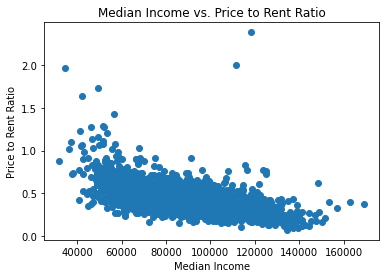

In [22]:
plt.scatter(price_rent_income_data['Median_Income'], price_rent_income_data['Price_to_Rent_Ratio'])
plt.xlabel('Median Income')
plt.ylabel('Price to Rent Ratio')
plt.title('Median Income vs. Price to Rent Ratio')
plt.show()

Educational attainment's influence on housing affordability is explored. Higher education levels often correlate with economic stability and housing demand.

In [23]:
query = """
SELECT 
    property.ZipCode,
    property."2024-10-31" AS Property_Oct_2024,
    rent."2024-10-31" AS Rent_Oct_2024,
    educational_attainment.Percent_Bachelors_Or_Higher,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN educational_attainment ON property.ZipCode = educational_attainment.ZipCode;
"""

price_rent_education_data = pd.read_sql_query(query, conn)
price_rent_education_data['Percent_Bachelors_Or_Higher'] = pd.to_numeric(
    price_rent_education_data['Percent_Bachelors_Or_Higher'], errors='coerce'
)
print(price_rent_education_data['Percent_Bachelors_Or_Higher'].head())
print(price_rent_education_data['Percent_Bachelors_Or_Higher'].dtype)
print(price_rent_education_data['Percent_Bachelors_Or_Higher'].isnull().sum())

correlation = price_rent_education_data[['Price_to_Rent_Ratio', 'Percent_Bachelors_Or_Higher']].corr()

print(correlation)

0    66.3
1    28.4
2    29.7
3    34.1
4    41.8
Name: Percent_Bachelors_Or_Higher, dtype: float64
float64
0
                             Price_to_Rent_Ratio  Percent_Bachelors_Or_Higher
Price_to_Rent_Ratio                     1.000000                    -0.487428
Percent_Bachelors_Or_Higher            -0.487428                     1.000000


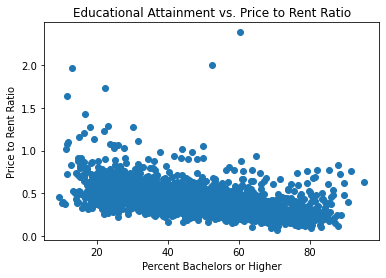

In [24]:
plt.scatter(price_rent_education_data['Percent_Bachelors_Or_Higher'], price_rent_education_data['Price_to_Rent_Ratio'])
plt.xlabel('Percent Bachelors or Higher')
plt.ylabel('Price to Rent Ratio')
plt.title('Educational Attainment vs. Price to Rent Ratio')
plt.show()

The relationship between employment metrics (employment and unemployment rates) and the price-to-rent ratio is analyzed. This shows how labor market conditions impact housing affordability and demand.

In [25]:
query = """
SELECT 
    property.ZipCode,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    employment_rate.Employment_Rate,
    employment_rate.Unemployment_Rate
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN employment_rate ON property.ZipCode = employment_rate.ZipCode;
"""

price_rent_employment_data = pd.read_sql_query(query, conn)

correlation = price_rent_employment_data[['Price_to_Rent_Ratio', 'Employment_Rate', 'Unemployment_Rate']].corr()

print(correlation)

                     Price_to_Rent_Ratio  Employment_Rate  Unemployment_Rate
Price_to_Rent_Ratio             1.000000        -0.248351           0.233564
Employment_Rate                -0.248351         1.000000          -0.474018
Unemployment_Rate               0.233564        -0.474018           1.000000


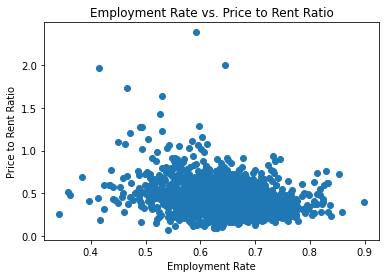

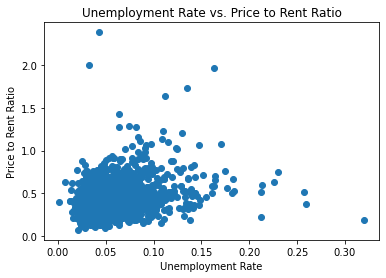

In [26]:
plt.scatter(price_rent_employment_data['Employment_Rate'], price_rent_employment_data['Price_to_Rent_Ratio'])
plt.xlabel('Employment Rate')
plt.ylabel('Price to Rent Ratio')
plt.title('Employment Rate vs. Price to Rent Ratio')
plt.show()

plt.scatter(price_rent_employment_data['Unemployment_Rate'], price_rent_employment_data['Price_to_Rent_Ratio'])
plt.xlabel('Unemployment Rate')
plt.ylabel('Price to Rent Ratio')
plt.title('Unemployment Rate vs. Price to Rent Ratio')
plt.show()

The correlation between median age and the price-to-rent ratio is calculated. This helps assess whether age demographics influence housing market trends.

In [27]:
query = """
SELECT 
    property.ZipCode,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    median_age.Median_Age_Approx
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN median_age ON property.ZipCode = median_age.ZipCode;
"""

price_rent_median_age_data = pd.read_sql_query(query, conn)

correlation = price_rent_median_age_data[['Price_to_Rent_Ratio', 'Median_Age_Approx']].corr()

print(correlation)

                     Price_to_Rent_Ratio  Median_Age_Approx
Price_to_Rent_Ratio             1.000000          -0.153794
Median_Age_Approx              -0.153794           1.000000


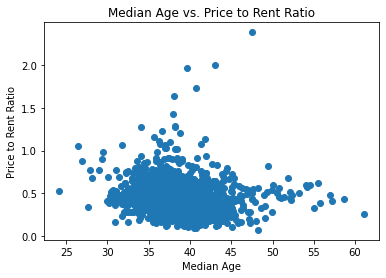

In [28]:
plt.scatter(price_rent_median_age_data['Median_Age_Approx'], price_rent_median_age_data['Price_to_Rent_Ratio'])
plt.xlabel('Median Age')
plt.ylabel('Price to Rent Ratio')
plt.title('Median Age vs. Price to Rent Ratio')
plt.show()

Homeownership and rental vacancy rates are analyzed in relation to the price-to-rent ratio. This provides insights into supply-side housing market dynamics.

In [29]:
query = """
SELECT 
    property.ZipCode,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    homeownership_rate.Homeowner_Vacancy_Rate,
    homeownership_rate.Rental_Vacancy_Rate,
    homeownership_rate.GRAPI_20_24_Percent,
    homeownership_rate.GRAPI_25_29_Percent,
    homeownership_rate.GRAPI_30_34_Percent,
    homeownership_rate.GRAPI_35_Plus_Percent
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN homeownership_rate ON property.ZipCode = homeownership_rate.ZipCode;
"""

price_rent_vacancy_data = pd.read_sql_query(query, conn)

price_rent_vacancy_data[['Homeowner_Vacancy_Rate', 'Rental_Vacancy_Rate', 
                         'GRAPI_20_24_Percent', 'GRAPI_25_29_Percent', 
                         'GRAPI_30_34_Percent', 'GRAPI_35_Plus_Percent']] = price_rent_vacancy_data[
    ['Homeowner_Vacancy_Rate', 'Rental_Vacancy_Rate', 
     'GRAPI_20_24_Percent', 'GRAPI_25_29_Percent', 
     'GRAPI_30_34_Percent', 'GRAPI_35_Plus_Percent']
].apply(pd.to_numeric, errors='coerce')

correlation = price_rent_vacancy_data[['Price_to_Rent_Ratio', 'Homeowner_Vacancy_Rate', 'Rental_Vacancy_Rate', 
                                       'GRAPI_20_24_Percent', 'GRAPI_25_29_Percent', 'GRAPI_30_34_Percent', 'GRAPI_35_Plus_Percent' ]].corr()

print(correlation)

                        Price_to_Rent_Ratio  Homeowner_Vacancy_Rate  \
Price_to_Rent_Ratio                1.000000                0.130165   
Homeowner_Vacancy_Rate             0.130165                1.000000   
Rental_Vacancy_Rate                0.067465                0.242376   
GRAPI_20_24_Percent               -0.115312               -0.093860   
GRAPI_25_29_Percent               -0.051526               -0.064448   
GRAPI_30_34_Percent               -0.022831               -0.010207   
GRAPI_35_Plus_Percent              0.232459                0.066170   

                        Rental_Vacancy_Rate  GRAPI_20_24_Percent  \
Price_to_Rent_Ratio                0.067465            -0.115312   
Homeowner_Vacancy_Rate             0.242376            -0.093860   
Rental_Vacancy_Rate                1.000000            -0.044519   
GRAPI_20_24_Percent               -0.044519             1.000000   
GRAPI_25_29_Percent               -0.047134             0.042757   
GRAPI_30_34_Percent    

Population growth rates are evaluated alongside housing affordability metrics to identify areas with both demographic growth and favorable housing conditions.

In [30]:
query = """
SELECT 
    property.ZipCode,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    population.Total_Population_2020,
    population.Growth_Percentage
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN population ON property.ZipCode = population.ZipCode;
"""

price_rent_population_data = pd.read_sql_query(query, conn)

correlation = price_rent_population_data[['Price_to_Rent_Ratio', 'Total_Population_2020', 'Growth_Percentage']].corr()

print(correlation)

                       Price_to_Rent_Ratio  Total_Population_2020  \
Price_to_Rent_Ratio               1.000000              -0.016655   
Total_Population_2020            -0.016655               1.000000   
Growth_Percentage                -0.045828               0.043514   

                       Growth_Percentage  
Price_to_Rent_Ratio            -0.045828  
Total_Population_2020           0.043514  
Growth_Percentage               1.000000  


In [31]:
filtered_data = population_data[
    (population_data['Growth_Percentage'] > 0) &
    (price_rent_population_data['Price_to_Rent_Ratio'] >= 1.9)
]

print(filtered_data)

     ZipCode  Total_Population_2010  Total_Population_2020  Growth_Percentage
1140   04412                   9482                   9672           2.003797


## Composite Index Creation
### Data Normalization
Key metrics (e.g., price-to-rent ratio, income, education, employment, population growth, and vacancy rates) are normalized to create a standardized comparison. Metrics like median income and median home price are inverted to align with the composite scoring logic.

In [32]:
query = """
SELECT 
    property.ZipCode,
    property.City,
    property.State,
    property."2024-10-31" AS Median_Home_Price,
    (rent."2024-10-31" / property."2024-10-31") * 100 AS Price_to_Rent_Ratio,
    income.Median_Income,
    educational_attainment.Percent_Bachelors_Or_Higher,
    employment_rate.Employment_Rate,
    population.Growth_Percentage,
    homeownership_rate.Rental_Vacancy_Rate
FROM property
JOIN rent ON property.ZipCode = rent.ZipCode
JOIN income ON property.ZipCode = income.ZipCode
JOIN educational_attainment ON property.ZipCode = educational_attainment.ZipCode
JOIN employment_rate ON property.ZipCode = employment_rate.ZipCode
JOIN population ON property.ZipCode = population.ZipCode
JOIN homeownership_rate ON property.ZipCode = homeownership_rate.ZipCode;
"""


data = pd.read_sql_query(query, conn)

columns_to_convert = ['Price_to_Rent_Ratio', 'Median_Income', 'Percent_Bachelors_Or_Higher',
                      'Employment_Rate', 'Growth_Percentage', 'Rental_Vacancy_Rate', 'Median_Home_Price']

for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
correlation_matrix = data[['Price_to_Rent_Ratio', 'Median_Income', 
                           'Percent_Bachelors_Or_Higher', 'Employment_Rate', 
                           'Growth_Percentage', 'Rental_Vacancy_Rate', 'Median_Home_Price']].corr()

print(correlation_matrix['Price_to_Rent_Ratio'])

# Normalize metrics
for col in ['Price_to_Rent_Ratio', 'Percent_Bachelors_Or_Higher', 'Employment_Rate', 
            'Growth_Percentage', 'Rental_Vacancy_Rate']:
    data[f'Normalized_{col}'] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# Add inverted metrics
data['Normalized_Median_Income'] = 1 - ((data['Median_Income'] - data['Median_Income'].min()) / 
                                        (data['Median_Income'].max() - data['Median_Income'].min()))
data['Normalized_Median_Home_Price'] = 1 - ((data['Median_Home_Price'] - data['Median_Home_Price'].min()) / 
                                            (data['Median_Home_Price'].max() - data['Median_Home_Price'].min()))

Price_to_Rent_Ratio            1.000000
Median_Income                 -0.562635
Percent_Bachelors_Or_Higher   -0.487093
Employment_Rate               -0.247904
Growth_Percentage             -0.045828
Rental_Vacancy_Rate            0.067272
Median_Home_Price             -0.591230
Name: Price_to_Rent_Ratio, dtype: float64


### Weighting and Scoring
Normalized metrics are assigned weights based on their importance in determining housing market attractiveness. A composite score is calculated for each zip code to rank them.

In [33]:
composite_score_weights = {
    'Normalized_Price_to_Rent_Ratio': 0.1,
    'Normalized_Median_Home_Price': 0.3,
    'Normalized_Median_Income': 0.2,
    'Normalized_Percent_Bachelors_Or_Higher': 0.15,
    'Normalized_Employment_Rate': 0.1,
    'Normalized_Growth_Percentage': 0.1,
    'Normalized_Rental_Vacancy_Rate': 0.05
}

data['Composite_Score'] = sum(data[col] * weight for col, weight in composite_score_weights.items())

### Sorting and Analysis

Zip codes are sorted by composite score to identify the most and least attractive housing markets. This final step synthesizes the analysis into actionable insights for decision-making.

In [34]:
data = data.sort_values(by='Composite_Score', ascending=False)

In [35]:
# Display highest ranking zip codes
print(data[['ZipCode', 'City', 'State','Composite_Score', 'Price_to_Rent_Ratio', 'Median_Home_Price', 'Growth_Percentage', 'Percent_Bachelors_Or_Higher']].head(20))

     ZipCode          City State  Composite_Score  Price_to_Rent_Ratio  \
1579   77054       Houston    TX         0.687998             0.931395   
1341   55414   Minneapolis    MN         0.661460             0.679168   
1797   20036    Washington    DC         0.660964             0.633830   
1767   55401   Minneapolis    MN         0.659393             0.624995   
1694   45219    Cincinnati    OH         0.656463             1.053819   
1522   78705        Austin    TX         0.655829             0.533180   
1785   28204     Charlotte    NC         0.653329             0.273628   
1594   30308       Atlanta    GA         0.653181             0.557199   
1774   15203    Pittsburgh    PA         0.652539             0.879415   
1784   30326       Atlanta    GA         0.651251             0.473272   
1611   80203        Denver    CO         0.650043             0.417313   
1626   37203     Nashville    TN         0.649749             0.357986   
1618   60654       Chicago    IL      

In [36]:
data = data.sort_values(by='Composite_Score', ascending=True)

# Display lowest ranking zip codes
print(data[['ZipCode', 'City', 'State','Composite_Score', 'Price_to_Rent_Ratio', 'Median_Home_Price', 'Growth_Percentage', 'Percent_Bachelors_Or_Higher']].head(20))

     ZipCode             City State  Composite_Score  Price_to_Rent_Ratio  \
1655   90210    Beverly Hills    CA         0.211255             0.156617   
1768   90402     Santa Monica    CA         0.311541             0.166399   
1586   90272      Los Angeles    CA         0.332206             0.276659   
1653   90265           Malibu    CA         0.338509             0.406861   
1692   85253  Paradise Valley    AZ         0.341672             0.074830   
751    94010     Hillsborough    CA         0.341831             0.092129   
1528   92651     Laguna Beach    CA         0.354593             0.184551   
1382   94306        Palo Alto    CA         0.359718             0.096705   
1361   10013         New York    NY         0.360216             0.181269   
238    95014        Cupertino    CA         0.364832             0.128500   
1723   92118         Coronado    CA         0.366210             0.195257   
1105   92660    Newport Beach    CA         0.367006             0.137382   

## Conclusion & Findings
The analysis reveals several key insights about the U.S. real estate market, focusing on areas of high rental investment potential and the factors influencing price-to-rent ratios. The count of zip codes meeting the "1% rule" indicates that Pennsylvania emerges as a strong contender with the highest number of qualifying zip codes (7), followed by Maryland and New York (3 each), and Florida and Ohio (2 each). These findings highlight Pennsylvania's prominence as a favorable state for rental investment opportunities.

The correlation analysis provides deeper insights into the factors affecting price-to-rent ratios. A moderately negative correlation between price-to-rent ratios and median income (-0.57) suggests that areas with lower incomes often have relatively higher rent compared to property prices, making them attractive for rental investments. Similarly, a weaker negative correlation with educational attainment (-0.49) implies that areas with higher educational levels tend to have lower price-to-rent ratios, potentially reflecting more stable and affluent housing markets.

Employment metrics show weaker correlations, with the employment rate negatively correlated (-0.25) and the unemployment rate slightly positively correlated (0.23) with price-to-rent ratios. These suggest that areas with stronger job markets may have less favorable rent-to-property-price ratios for investors, possibly due to higher property values.

Demographic factors such as median age (-0.15) and population growth (-0.04) show minimal impact on price-to-rent ratios, indicating that other variables may play more critical roles in determining rental investment attractiveness. Vacancy rates show weak correlations, with homeowner vacancy rates (0.13) and rental vacancy rates (0.07) having limited influence on price-to-rent ratios.

The composite scoring approach further refines the analysis by integrating multiple metrics such as price-to-rent ratios, median income, employment rate, educational attainment, and population growth. High-ranking zip codes, such as those in Houston, Minneapolis, and Washington, D.C., demonstrate strong rental investment potential with balanced scores across these factors. On the other hand, lower-ranking zip codes, including Beverly Hills and Santa Monica, exhibit low price-to-rent ratios, high property prices, and limited growth potential, making them less attractive for rental investments despite their affluent profiles.

In conclusion, the analysis identifies Pennsylvania, particularly the Philadelphia area, as a leading state for rental investment opportunities based on the "1% rule," while demographic, economic, and market factors provide additional context for assessing market attractiveness. The composite scoring system provides a comprehensive framework for evaluating zip codes, empowering investors to make informed decisions about where to allocate their resources.